In [2]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import pandas as pd
import requests
from io import StringIO
import re
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import numpy as np
from sklearn.decomposition import PCA 
import umap.umap_ as umap
import matplotlib.pyplot as plt
import hdbscan
pd.set_option('display.max_colwidth', None)

In [3]:
sheet_name_lsit = ['Sci/2', 'Sci_Extra/1', 'Sci/1', 'Sci_Extra/2', 'Engineering/1', 'Engineering_Extra/1', 'Engineering/2', 'Engineering_Extra/2', 'SIIT/2', 'SIIT/1', 'Innovation_Extra/1', 'Innovation_Extra/2', 'CIS_Extra/1', 'CIS/1', 'CIS_Extra/2', 'CIS/2']

In [4]:
sheet_id = "1ExtEUwVLi5Y_mmqxNd0oX7WrWzj8n6TeBLcQg7Xu0GU"
dataframe = pd.DataFrame(columns=["code", "desc", "add1", "add2", "add3","ma"])

for sheet_name in sheet_name_lsit:
    url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
    response = requests.get(url)
    decoded_content = response.content.decode('utf-8')
    data_tem =  pd.read_csv(StringIO(decoded_content))
    dataframe = pd.concat([dataframe, data_tem], ignore_index=True)

print(dataframe.shape)
for i in dataframe.columns:
    dataframe[f"{i}"] = dataframe[f"{i}"].str.strip().str.lower()


dataframe.drop_duplicates(subset=["code"],inplace=True)
dataframe.dropna(subset=["desc","code"],inplace=True)
print(dataframe.shape)

(4272, 6)
(1919, 6)


In [5]:
df = dataframe[dataframe.duplicated(subset=["desc"], keep=False)]
print(df.shape)
dataframe.drop_duplicates(subset=["desc"], keep=False,inplace=True)
df = df.drop_duplicates(subset="desc")
df["code"] = "Group_duplicated"
print(df.shape)
dataframe = pd.concat([df,dataframe])

(151, 6)
(74, 6)


In [6]:
# df["add1"] = df["add1"].str.replace("คป","")
df.head()

,code,desc,add1,add2,add3,ma
19,Group_duplicated,"discussion on topics of current interest in applied mathematics, basic skills for academic reading, proposal topic regulations and procedures, literature review, designing and planning of the project, report writing and topic of project presentation.",['disciplinary course(s): am260\nสอบได้ คป.260 หรือ ได้รับอนุมัติจากผู้บรรยาย'],['consecutive course(s): am460'],[],sci
59,Group_duplicated,"biology of animal behaviour, behavioural genetics, memory and learning, foraging and ingestive behaviour, social and reproductive behaviour, farm animal behaviour, regulations and assessment of animal welfare, field trips.",[],[],[],sci
213,Group_duplicated,"senior projects will be assigned or approved by the department. this course prepares students for developing a proposal for doing research, writing research papers, and presenting the proposal to the committee.",['disciplinary course(s): cs300 and cs301 or\ncs300 and cs302\nสำหรับนักศึกษาตั้งแต่ชั้นปีที่ 3 ขึ้นไป'],['consecutive course(s): cs403'],[],sci
238,Group_duplicated,"deterministic and stochastic grammars, morphological analysis, syntax analysis, semantic analysis, discourse analysis, and applications (e.g. machine translation, speech recognition and synthesis, and text mining)",['disciplinary course(s): cs265'],[],[],sci
255,Group_duplicated,"integration of principles and theories to be applied to systematically solve complex problems in the environment. to distinguish, synthesize and analyze information from world current online information. in order to properly present the facts to the public in accordance with environmentalist ethics.",[],[],[],sci


In [7]:
pattern = r"[A-Za-zก-ฮ]{1,2}\.? ?\d{3}"

def extract_courses(row):
    listt = []
    if isinstance(row, str):
        matches = re.findall(pattern, row)  
        listt.extend(matches)
        return listt
    return None 

dataframe["cancel_course"] = dataframe["add1"].apply(extract_courses) + dataframe["add2"].apply(extract_courses)
dataframe.head()

,code,desc,add1,add2,add3,ma,cancel_course
19,Group_duplicated,"discussion on topics of current interest in applied mathematics, basic skills for academic reading, proposal topic regulations and procedures, literature review, designing and planning of the project, report writing and topic of project presentation.",['disciplinary course(s): am260\nสอบได้ คป.260 หรือ ได้รับอนุมัติจากผู้บรรยาย'],['consecutive course(s): am460'],[],sci,"[am260, คป.260, am460]"
59,Group_duplicated,"biology of animal behaviour, behavioural genetics, memory and learning, foraging and ingestive behaviour, social and reproductive behaviour, farm animal behaviour, regulations and assessment of animal welfare, field trips.",[],[],[],sci,[]
213,Group_duplicated,"senior projects will be assigned or approved by the department. this course prepares students for developing a proposal for doing research, writing research papers, and presenting the proposal to the committee.",['disciplinary course(s): cs300 and cs301 or\ncs300 and cs302\nสำหรับนักศึกษาตั้งแต่ชั้นปีที่ 3 ขึ้นไป'],['consecutive course(s): cs403'],[],sci,"[cs300, cs301, cs300, cs302, cs403]"
238,Group_duplicated,"deterministic and stochastic grammars, morphological analysis, syntax analysis, semantic analysis, discourse analysis, and applications (e.g. machine translation, speech recognition and synthesis, and text mining)",['disciplinary course(s): cs265'],[],[],sci,[cs265]
255,Group_duplicated,"integration of principles and theories to be applied to systematically solve complex problems in the environment. to distinguish, synthesize and analyze information from world current online information. in order to properly present the facts to the public in accordance with environmentalist ethics.",[],[],[],sci,[]


In [8]:
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
import time

In [9]:
model_name = "sentence-transformers/all-MiniLM-L6-v2" 
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [10]:
model1 = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
model2 = SentenceTransformer('paraphrase-mpnet-base-v2') 
Big_model = SentenceTransformer("all-mpnet-base-v2")

In [13]:
def create_embeddings1():
    dis = list(dataframe["desc"])
    embeddings = model1.encode(dis)
    return embeddings
dataframe["embed1"] = create_embeddings1().tolist()

def create_embeddings2():
    dis = list(dataframe["desc"])
    embeddings = model2.encode(dis)
    return embeddings
dataframe["embed2"] = create_embeddings2().tolist()

def create_embeddings3():
    dis = list(dataframe["desc"])
    embeddings = Big_model.encode(dis)
    return embeddings
dataframe["embed3"] = create_embeddings3().tolist()

embeddings1 = np.array(dataframe["embed1"].tolist())
embeddings2 = np.array(dataframe["embed2"].tolist())
embeddings3 = np.array(dataframe["embed3"].tolist())

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')
clusters_embed1 = clusterer.fit_predict(embeddings1)
dataframe["HDBSCAN1"] = clusters_embed1

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')
clusters_embed2 = clusterer.fit_predict(embeddings2)
dataframe["HDBSCAN2"] = clusters_embed2

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')
clusters_embed3 = clusterer.fit_predict(embeddings3)
dataframe["HDBSCAN3"] = clusters_embed3

In [ ]:
import seaborn as sns

n_neighbors_list = [20, 30 , 40]
min_dist_list = [0.001, 0.1, 0.2]
spread_list = [0.8, 1.0, 1.5]

for n_neighbors in n_neighbors_list:
    for min_dist in min_dist_list:
        for spread in spread_list:
            umap_reducer = umap.UMAP(
                n_components=2,
                n_neighbors=n_neighbors,
                min_dist=min_dist,
                spread=spread,
                random_state=42
            )
            
            embedding = umap_reducer.fit_transform(embeddings3)
            plt.figure(figsize=(16, 10))
            plt.scatter(embedding[:, 0], embedding[:, 1], s=2, cmap='viridis')
            # sns.scatterplot(
            #     x=embeddings_2d[:, 0],
            #     y=embeddings_2d[:, 1],
            #     s=4,
            #     hue=dataframe["HDBSCAN2"],
            #     palette="tab10",
            #     style=dataframe["HDBSCAN2"],
            # )
            plt.title(f"UMAP Visualization, {n_neighbors} ,{min_dist} , {spread}")
            plt.show()


C:\Users\LENOVO\AppData\Roaming\Python\Python312\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


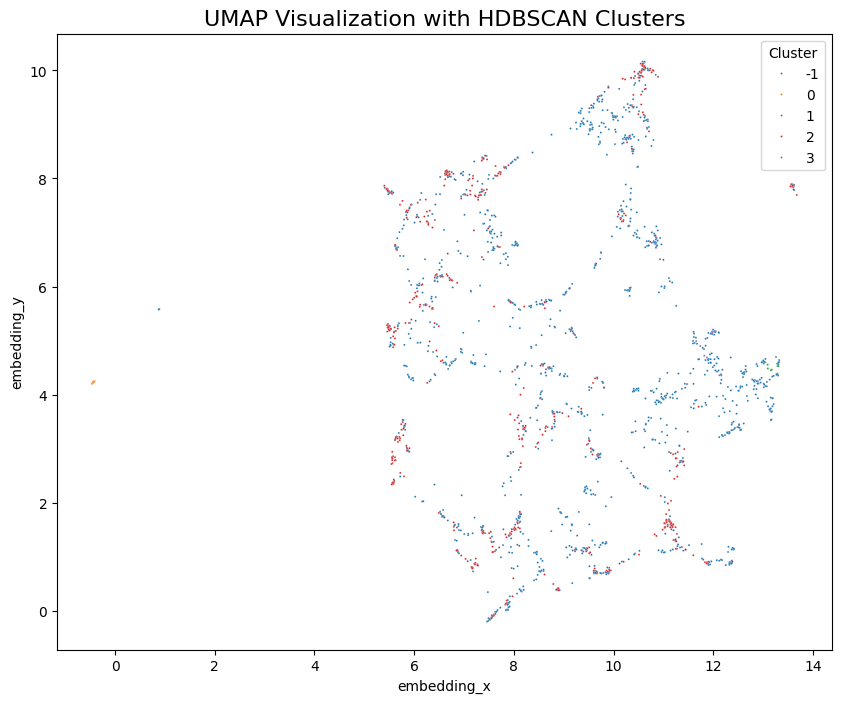

In [ ]:
import umap
import hdbscan
import pandas as pd

# UMAP Dimensionality Reduction
umap_reducer = umap.UMAP(
    n_components=2,
    n_neighbors=20,
    min_dist=0.01,
    spread=1.0,
    random_state=42
)

# Reduce the embeddings
embedding = umap_reducer.fit_transform(embeddings3)

# Add the 2D embedding as separate columns
dataframe["embedding_x"] = embedding[:, 0]
dataframe["embedding_y"] = embedding[:, 1]

# Perform HDBSCAN Clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, metric='euclidean')
clusters = clusterer.fit_predict(embeddings3)

# Add the cluster labels to the DataFrame
dataframe["HDBSCAN_clusters"] = clusters

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=dataframe["embedding_x"],
    y=dataframe["embedding_y"],
    hue=dataframe["HDBSCAN_clusters"],
    palette="tab10",
    s=2,
    alpha=1,
)

plt.title("UMAP Visualization with HDBSCAN Clusters", fontsize=16)
plt.legend(title="Cluster", loc="best", bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
kmean1 = KMeans(n_clusters=5, random_state=0).fit(embeddings1)
clusters_embed1 = kmean1.labels_

kmean2 = KMeans(n_clusters=5, random_state=0).fit(embeddings2)
clusters_embed2 = kmean2.labels_

kmean3 = KMeans(n_clusters=5, random_state=0).fit(embeddings3)
clusters_embed3 = kmean2.labels_

dataframe["Kmean_embed1"] = clusters_embed1
dataframe["Kmean_embed2"] = clusters_embed2
dataframe["Kmean_embed3"] = clusters_embed3

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')
clusters_embed1 = clusterer.fit_predict(embeddings1)
dataframe["HDBSCAN1"] = clusters_embed1

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')
clusters_embed2 = clusterer.fit_predict(embeddings2)
dataframe["HDBSCAN2"] = clusters_embed2

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')
clusters_embed3 = clusterer.fit_predict(embeddings3)
dataframe["HDBSCAN3"] = clusters_embed3

In [23]:
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

# คำนวณค่า cosine similarity สำหรับทุกคู่ของ embeddings
def compute_similarity_matrix(dataframe, threshold=0.8):
    embeddings = np.vstack(dataframe["embed2"].dropna().to_numpy())   # รวม embeddings เป็น array
    similarity_matrix = cosine_similarity(embeddings)  # คำนวณค่า similarity matrix

    pairs = []
    for i in range(len(similarity_matrix)):
        for j in range(i + 1, len(similarity_matrix)):
            if similarity_matrix[i, j] > threshold:
                # Check if the pair is in the cancel_course column
                course_i = dataframe.iloc[i]["code"]  # Get course code for row i
                course_j = dataframe.iloc[j]["code"]  # Get course code for row j
                cancel_i = dataframe.iloc[i]["cancel_course"]  # Get canceled courses for row i
                cancel_j = dataframe.iloc[j]["cancel_course"]  # Get canceled courses for row j
                ii = dataframe.iloc[i]["ma"]  # Get canceled courses for row i
                jj = dataframe.iloc[j]["ma"]  # Get canceled courses for row j


                # Only add the pair if it is not canceled for both courses
                # and jj not in ii and ii not in jj
                if course_j not in cancel_i and course_i not in cancel_j and jj not in ii and ii not in jj:
                    pairs.append((i, j))  # Append the pair if conditions are met

        dataframe["valid_pairs"] = dataframe["code"].apply(
            lambda x: [i for i in pairs if x in i]
        )
    return pairs

pairs = compute_similarity_matrix(dataframe)

In [28]:
df[df['valid_pairs'].map(len) >1 ]

KeyError: 'valid_pairs'

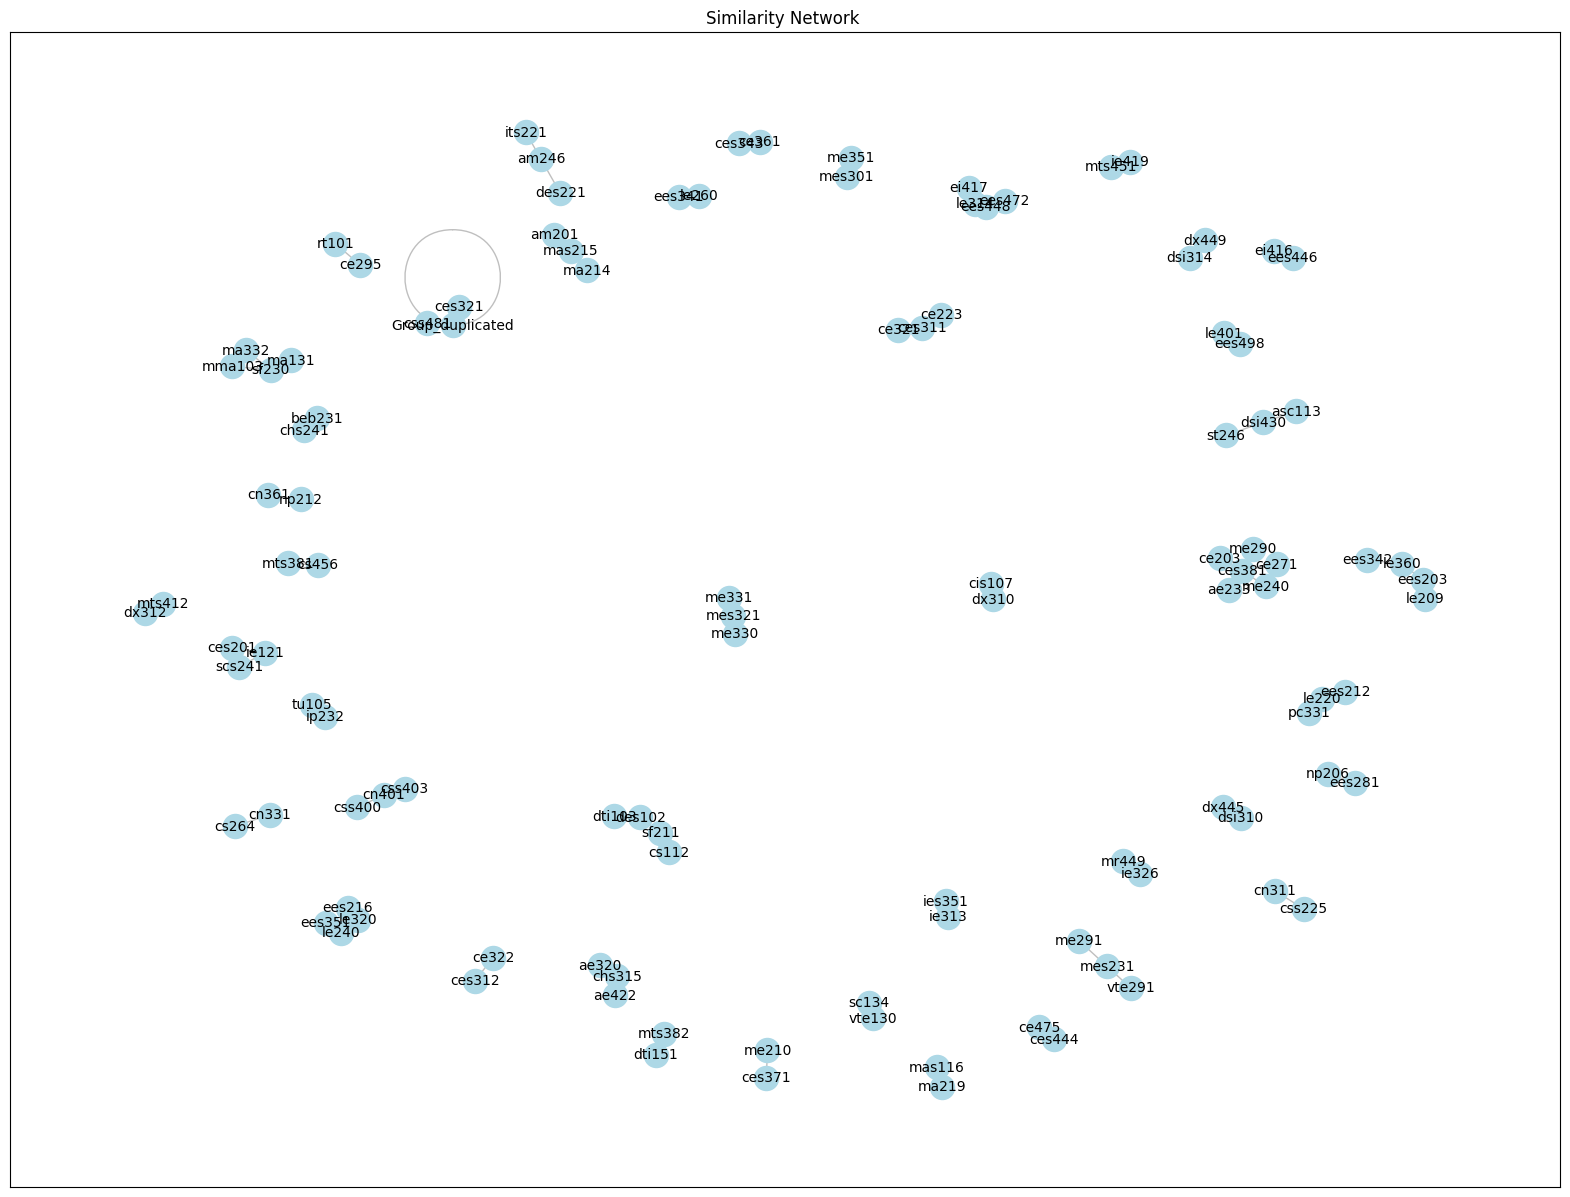

In [ ]:
def plot_similarity_graph(dataframe,pairs):
    codes = dataframe["code"].tolist()          
    G = nx.Graph()
    G.add_edges_from([(codes[i], codes[j]) for i, j in pairs])  

    plt.figure(figsize=(20, 15))
    pos = nx.spring_layout(G, seed=42) 
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=10, font_color="black") 

    plt.title(f"Similarity Network ")
    plt.show()

plot_similarity_graph(dataframe,pairs=pairs)

In [ ]:
dataframe[dataframe["valid_pairs"]]

TypeError: unhashable type: 'list'

In [18]:
dataframe[dataframe["code"] == "chs315"]

,code,desc,add1,add2,add3,ma,cancel_course,embed1,embed2,embed3,valid_pairs
3423,chs315,"impacts of environmental pollution, environmental quality standards, sources and characteristics of industrial wastes and treatment methods, hazardous wastes and disposal methods.",[],[],[],si,[],"[0.07481036335229874, -0.01932881772518158, 0.06984058767557144, -0.016076168045401573, 0.01662326790392399, 0.022566035389900208, -0.032143138349056244, 0.05517370626330376, -0.0698268711566925, 0.015392939560115337, -0.01667996309697628, -0.04860227555036545, -0.03115924447774887, 0.01815180666744709, -0.07498545199632645, -0.034058600664138794, 0.06686892360448837, 0.0036764589603990316, -0.029243795201182365, -0.010694717057049274, 0.07970671355724335, 0.01809464767575264, 0.0032621175050735474, 0.010354424826800823, -0.09292037039995193, -0.01174749992787838, -0.003872228553518653, -0.02322196587920189, -0.03392935171723366, -0.026368407532572746, 0.02256171591579914, 0.09430395811796188, 0.0472271554172039, -0.06660874933004379, -0.045833878219127655, 0.00973525084555149, 0.04907429590821266, -0.01807268150150776, 0.0471893772482872, 0.005272668320685625, -0.03693002462387085, -0.015481011942029, -0.036814820021390915, -0.027585947886109352, -0.03850006312131882, -0.024462852627038956, -0.0022502513602375984, -0.11050286144018173, -0.05582970753312111, -0.053610943257808685, 0.07168606668710709, 0.03862564265727997, 0.007487120572477579, -0.030614098533988, 0.04976298287510872, -0.14418207108974457, -0.040103744715452194, -0.04164529964327812, -0.08967724442481995, -0.013992520049214363, 0.009858008474111557, -0.02050427533686161, -0.0687578022480011, -0.022356370463967323, 0.08633992820978165, -0.04986318200826645, -0.038576964288949966, 0.06612139940261841, -0.022456834092736244, -0.012760072946548462, -0.05097498372197151, -0.07750384509563446, -0.03427908197045326, -0.08331052958965302, -0.052622366696596146, 0.03289245069026947, 0.03466456010937691, -0.017720652744174004, -0.01863773912191391, -0.027513252571225166, -0.0028894369024783373, -0.02785605378448963, 0.061919648200273514, 0.0017659084405750036, 0.01031315978616476, 0.062046755105257034, -0.05475329980254173, -0.01898775063455105, -0.018445085734128952, 0.014854549430310726, 0.058828774839639664, 0.002730113686993718, 0.12226743996143341, -0.017432017251849174, 0.004984662402421236, 0.06203708052635193, 0.010341750457882881, 0.06092255562543869, 0.1077151820063591, -0.013030210509896278, ...]","[-0.11442016065120697, 0.18434366583824158, 0.011370955035090446, -0.07014277577400208, 0.08569169789552689, -0.02858876995742321, 0.11400646716356277, 0.022519215941429138, -0.04216274991631508, -0.1579897254705429, -0.04622478038072586, 0.220266655087471, -0.13299313187599182, 0.01789535954594612, -0.028531257063150406, 0.05099020153284073, 0.06986988335847855, -0.015540732070803642, -0.2799161672592163, 0.1291673332452774, -0.036479465663433075, -0.07427391409873962, -0.10653237998485565, 0.11983858793973923, -0.11358872801065445, 0.10977818816900253, 0.1647440791130066, 0.07461625337600708, 0.05999051034450531, 0.045262113213539124, 0.14662304520606995, 0.06472751498222351, 0.19514678418636322, 0.03580125421285629, 0.00272874697111547, -0.02372901141643524, -0.13773423433303833, 0.14121626317501068, 0.1590035855770111, 0.004306143615394831, -0.004212069325149059, -0.05641224980354309, 0.0053136213682591915, 0.14814366400241852, 0.07993898540735245, -0.07972071319818497, -0.12909193336963654, -0.01256251148879528, 0.12768948078155518, -0.028261428698897362, -0.10903516411781311, 0.22819676995277405, -0.1864183396100998, 0.034580864012241364, -0.18546193838119507, 0.19106966257095337, 0.04758632555603981, -0.10319267213344574, -0.10059505701065063, -0.16064506769180298, -0.06776721030473709, 0.044414762407541275, 0.03866983577609062, 0.04073594510555267, -0.04235357418656349, -0.06659210473299026, 0.16259765625, 0.18064367771148682, 0.022294623777270317, 0.08274485170841217, 0.102067

In [ ]:
dataframe[dataframe["code"] == "ce361"][["desc"]]

,desc
2258,historical development of highways; highway administration; principles of highway planning and traffic analysis; geometric design and operations; highway finance and economic; flexible and rigid pavement design; highway materials; construction and maintenance of highways; interaction between traffic demand and land use; design of roads in rural and urban areas.


In [ ]:
text = "development of critical thinking through questioning, analytical, synthetic and evaluation skills. students learn how to read without necessarily accepting all the information presented in the text, but rather consider the content in depth, taking into account the objectives, perspectives, assumptions, bias and supporting evidence, as well as logic or strategies leading to the author’s conclusion. the purpose is to apply these methods to students’ own persuasive writing based on information researched from various sources, using effective presentation techniques."

In [ ]:
dataframe[dataframe["desc"] == text]

TF-IDF